# HairBnb

Modeling rental properties based on demographics and economics.

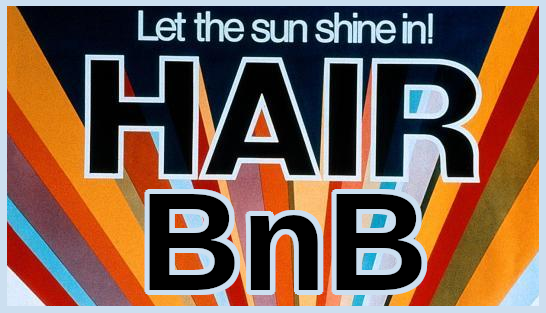

## Objective

In this study we assume that Airbnb wants to conduct a study on how they can improve their current rental programs for tourists and visiting professionals in either or both of the cities of Seattle and Boston. 

### Features to be explored:

 - Listings: details about each rental property available to customers
 - Calendar: when and what cost is each listing available
 - Reviews: reviews left by customers
 - Additional Datasets: Demographics, Econ State, Real Estate Prices, Venues

### Questions to be anwsered:
What is the expected demand and supply for Airbnb rental properties in Seattle/Boston required for the next 3 years?

Could prices/amenities be improved to help increase customers for a property?

### Purposed approach:
  -  model AirBnB to determine which properties are under/over priced
  -  model economic factors across state to predict a travel-score
  -  use travel-score and local demographics to recommend a price adjustment

## Import Libraries 

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Dropout,
                                     Activation,
                                     BatchNormalization,
                                     Flatten)
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import MeanSquaredLogarithmicError

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import re
path = './Data'

## Load Data

In [2]:
df_list = pd.read_csv(f'{path}/18189_seattle_listings.csv')
df_demo = pd.read_csv(f'{path}/36775_demographics.csv')
df_econ = pd.read_csv(f'{path}/61255_econ_state.csv')

## Cleanse Data

In [3]:
# df_list

# cols to be converted to numbers
convert2num_cols = ['price', 'extra_people', 'cleaning_fee', 'security_deposit']
doll2num = lambda s: s.str.replace('[$,]','', regex=True)

# create clean df
cdf_list = df_list[convert2num_cols].apply(doll2num).apply(pd.to_numeric)

# t/f to int
cdf_list['instant_bookable'] = (df_list['instant_bookable']=='t').astype(int)

# add in all the other numeric values
numberic_cols = ['host_total_listings_count', 'accommodates', 'bathrooms',
 'bedrooms', 'beds', 'square_feet', 'guests_included', 'minimum_nights',
 'maximum_nights', 'availability_30', 'availability_60', 'availability_90',
 'availability_365', 'number_of_reviews', 'review_scores_rating',
 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
 'review_scores_communication', 'review_scores_location', 'review_scores_value']

cdf_list = cdf_list.join(df_list[numberic_cols])

# convert to catogory
# ingoring... 'amenities' ... for now
#pd.get_dummies(df_list.amenities) # {"Air Conditioning",Kitchen,"Free
convert2cat_cols = [ 'property_type', 'room_type', 'bed_type',
                     'cancellation_policy' ]
scrub = lambda s: s.str.replace('[& /]','', regex=True)
cdf_list = cdf_list.join(df_list[convert2cat_cols].apply(scrub))

#pd.get_dummies(data = df_list, columns = convert2cat_cols, drop_first = True).head() # not quite, why not?
cdf_list = pd.get_dummies(data = cdf_list, drop_first = True)  # one hot mamma

# impute
cdf_list.cleaning_fee.fillna(0, inplace=True)
cdf_list.security_deposit.fillna(0, inplace=True)
cdf_list.host_total_listings_count.fillna(1, inplace=True)
cdf_list.bathrooms.fillna(1, inplace=True)
cdf_list.bedrooms.fillna(1, inplace=True)
cdf_list.beds.fillna(1, inplace=True)
cdf_list.square_feet.fillna(cdf_list.square_feet.min(), inplace=True)

cdf_list.review_scores_rating.fillna(cdf_list.review_scores_rating.mean(), inplace=True)
cdf_list.review_scores_accuracy.fillna(cdf_list.review_scores_accuracy.mean(), inplace=True)
cdf_list.review_scores_cleanliness.fillna(cdf_list.review_scores_cleanliness.mean(), inplace=True)

cdf_list.review_scores_checkin.fillna(cdf_list.review_scores_checkin.mean(), inplace=True)
cdf_list.review_scores_communication.fillna(cdf_list.review_scores_communication.mean(), inplace=True)
cdf_list.review_scores_location.fillna(cdf_list.review_scores_location.mean(), inplace=True)

cdf_list.review_scores_value.fillna(cdf_list.review_scores_value.mean(), inplace=True)
cdf_list.review_scores_location.fillna(cdf_list.review_scores_location.mean(), inplace=True)
cdf_list.review_scores_location.fillna(cdf_list.review_scores_location.mean(), inplace=True)

# add total price
cdf_list['total_price'] = cdf_list['price'] + cdf_list['cleaning_fee']

# drop high corr
#cdf_list = cdf_list.drop(columns=['price', 'cleaning_fee'])
cdf_list = cdf_list.drop(columns=['cleaning_fee'])
#cdf_list = cdf_list.drop(columns=['availability_60', 'availability_90', 'availability_30',
#                                 'beds', 'bedrooms'])

#cdf_list.info() # nice
#cdf_list.isna().sum()

## Analyze

In [4]:
def report_corr(df, threshold=.001):
    assert (threshold<=1 and threshold > 0), "Threshold is invalid.  The valid range is between 0 and 1."
    corr_mat = df.corr(numeric_only=True)
    sol = (corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
                      .stack()
                      .sort_values(ascending=False))

    for index, value in sol.items():
        if abs(value) >= threshold:
            print('%1.2f: %s vs %s' %(value, index[0], index[1]))
    
report_corr(cdf_list,.50) 

0.97: availability_60 vs availability_90
0.95: price vs total_price
0.94: availability_30 vs availability_60
0.88: availability_30 vs availability_90
0.86: accommodates vs beds
0.77: accommodates vs bedrooms
0.75: bedrooms vs beds
0.72: accommodates vs total_price
0.69: review_scores_rating vs review_scores_value
0.68: review_scores_checkin vs review_scores_communication
0.67: bedrooms vs total_price
0.65: beds vs total_price
0.65: price vs accommodates
0.64: review_scores_rating vs review_scores_cleanliness
0.63: price vs bedrooms
0.62: availability_90 vs availability_365
0.62: review_scores_rating vs review_scores_accuracy
0.61: bathrooms vs bedrooms
0.59: price vs beds
0.57: availability_60 vs availability_365
0.56: review_scores_accuracy vs review_scores_value
0.55: bathrooms vs total_price
0.54: review_scores_accuracy vs review_scores_cleanliness
0.54: review_scores_rating vs review_scores_communication
0.54: accommodates vs bathrooms
0.53: accommodates vs guests_included
0.53: ba

### Model Rental Price with ANN

see also: https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [31]:
# seperate our predictors from the target
X, y = cdf_list.drop(columns=['total_price']), cdf_list.total_price

# split ratios
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# data set prep
X, y = cdf_list.drop(columns=['total_price']), cdf_list.total_price

# do the splits, first the training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (1-train_ratio),
                                                    random_state = 42)
# then the validation                                                    
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(X_train), len(X_val), len(X_test))

3054 382 382


In [7]:
def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled

# scale our data
X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

X_train_scaled.head()

,price,extra_people,security_deposit,instant_bookable,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,...,property_type_Treehouse,property_type_Yurt,room_type_Privateroom,room_type_Sharedroom,bed_type_Couch,bed_type_Futon,bed_type_Pull-outSofa,bed_type_RealBed,cancellation_policy_moderate,cancellation_policy_strict
0,-1.034900,-0.607664,-0.585919,-0.423262,-0.213615,-1.190519,-0.441437,-0.353436,-0.655632,-0.128576,...,-0.031357,-0.018098,1.530149,-0.178204,-0.057316,-0.134164,-0.109217,0.203985,-0.697750,1.313146
1,-0.691485,-0.607664,-0.168479,-0.423262,-0.213615,-0.683286,-0.441437,-0.353436,-0.655632,-0.128576,...,-0.031357,-0.018098,1.530149,-0.178204,-0.057316,-0.134164,-0.109217,0.203985,1.433178,-0.761530
2,-0.536394,-0.607664,-0.585919,-0.423262,-0.213615,-0.683286,-0.441437,-0.353436,-0.655632,-0.128576,...,-0.031357,-0.018098,1.530149,-0.178204,-0.057316,-0.134164,-0.109217,0.203985,-0.697750,-0.761530
3,0.239060,-0.607664,-0.585919,-0.423262,-0.213615,-0.176053,-0.441437,-0.353436,-0.655632,-0.128576,...,-0.031357,-0.018098,-0.653531,-0.178204,-0.057316,-0.134164,-0.109217,0.203985,1.433178,-0.761530
4,-0.791186,-0.607664,-0.585919,-0.423262,-0.181206,-0.683286,-0.441437,-0.353436,-0.655632,-0.128576,...,-0.031357,-0.018098,1.530149,-0.178204,-0.057316,-0.134164,-0.109217,0.203985,1.433178,-0.761530


In [30]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.001
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, input_shape=(48,), kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model

# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# build the model
model = build_model_using_sequential()

In [9]:
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)

In [11]:
# train the model
history = model.fit(
    X_train_scaled.values, 
    y_train.values, 
    validation_data=(X_val, y_val),
    epochs=10, 
    batch_size=64,
)

Epoch 1/10
48/48 [==============================] - 2s 19ms/step - loss: 6.5880 - mean_squared_logarithmic_error: 6.5520 - val_loss: 19.4745 - val_mean_squared_logarithmic_error: 19.4806
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2257 - mean_squared_logarithmic_error: 0.2253 - val_loss: 22.9673 - val_mean_squared_logarithmic_error: 22.9727
Epoch 3/10
48/48 [==============================] - 0s 10ms/step - loss: 0.1370 - mean_squared_logarithmic_error: 0.1368 - val_loss: 23.4693 - val_mean_squared_logarithmic_error: 23.4738
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1114 - mean_squared_logarithmic_error: 0.1113 - val_loss: 23.6634 - val_mean_squared_logarithmic_error: 23.6673
Epoch 5/10
48/48 [==============================] - 0s 9ms/step - loss: 0.0981 - mean_squared_logarithmic_error: 0.0980 - val_loss: 23.6355 - val_mean_squared_logarithmic_error: 23.6389
Epoch 6/10
48/48 [==============================] - 0s 10ms/step -

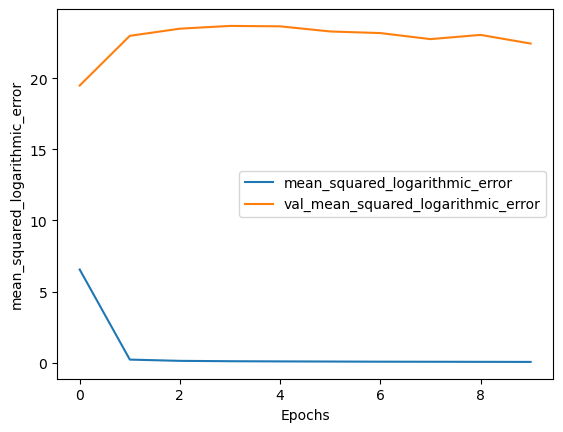

In [12]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [13]:
X_test['prediction'] = model.predict(X_test_scaled)

12/12 [==============================] - 0s 3ms/step


In [14]:
#X_test
display(y_test.head())
display(X_test['prediction'].head())

2823     90.0
3736    210.0
239     948.0
1717     70.0
2392    218.0
Name: total_price, dtype: float64

2823     72.531952
3736    182.630737
239     949.286682
1717     66.613129
2392    162.783325
Name: prediction, dtype: float32

## Appendix 0. Initial EDA 

### List EDA

In [15]:
# explore data
print(f'Dups: {df_list.duplicated().sum()}')
print(f'Columns w/missing values: {df_list.columns[df_list.isnull().any()].tolist()}')

Dups: 0
Columns w/missing values: ['summary', 'space', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'zipcode', 'property_type', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'reviews_per_month']


In [16]:
col_with_missing = df_list.columns[df_list.isnull().any()].tolist()

In [17]:
# explore numberic and object
nasum = lambda s: df_list[s].isna().sum()

cats = df_list.select_dtypes(include=['object']).columns.tolist()
nums = df_list.select_dtypes(include=np.number).columns.tolist()

def get_nunique(df, col, threshold = 0):
    for c in col:
        n = df[c].nunique()
        if n>threshold:
            print(f'{c}: {df[c].nunique()}')

def nget_nunique(df, col, threshold = 0):
    for c in col:
        n = df[c].nunique()
        if n<=threshold:
            print(f'{c}: {df[c].nunique()}')

In [18]:
#get_nunique(df_list, cats, 100)
#nget_nunique(df_list, cats, 100)
#df_list.bed_type

In [19]:
# Object columns to features

# convert to numbers
convert2num_cols = ['price', 'cleaning_fee' ]

# convert to catogory
convert2cat_cols = ['amenities', 'property_type', 'room_type', 'bed_type', 'security_deposit',
                    'extra_people', 'instant_bookable', 'cancellation_policy' ]
df_list['instant_bookable'].nunique()

2

In [20]:
#get_nunique(df_list, nums, -1000)

In [21]:
# Numberic columns to features (plus above)
numberic_cols = ['host_total_listings_count',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

## Demo EDA

In [22]:
cats = df_demo.select_dtypes(include=['object']).columns.tolist()
nums = df_demo.select_dtypes(include=np.number).columns.tolist()

In [23]:
#get_nunique(df_demo, cats, 0)
#get_nunique(df_demo, nums, 0)
df_demo[((df_demo.city.str.contains('Seattle')) & (df_demo.state=='WA')) |
        ((df_demo.city.str.contains('Boston')) & (df_demo.state=='MA'))]

,city,state,population,5_years_or_less,5-9_years,10-14_years,15-19_years,20-24_years,25-34_years,35-44_years,...,"$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000-$99,999","$100,000_or_more",median_household_income,mean_household_income
340,Boston,MA,4311208,242795,243633,251064,291305,314663,641269,560973,...,1.8,7.3,11.6,18.2,16.4,8.0,14.2,21.4,40143,40143
2915,Seattle,WA,3223799,207129,197733,191819,188401,223738,525583,466363,...,2.0,9.3,12.9,18.5,15.4,7.7,13.2,19.8,38662,38662


## Econ EDA

In [24]:
cats = df_econ.select_dtypes(include=['object']).columns.tolist()
nums = df_econ.select_dtypes(include=np.number).columns.tolist()

In [25]:
get_nunique(df_econ, cats, 0)
#get_nunique(df_econ, nums, 0)
#df_demo[df_demo.city.str.contains('Seattle')]

state: 51


,GDP,PersonalIncome,Unemployment
2005-04-01,290007.000000,2.307844e+08,5.640970
2005-05-01,292730.671693,2.293275e+08,5.595922
2005-06-01,294690.144221,2.317191e+08,5.574738
2005-07-01,295759.000000,2.338853e+08,5.578785
2005-08-01,296008.496083,2.352805e+08,5.586531
...,...,...,...
2016-10-01,474732.000000,3.919483e+08,5.453466
2016-11-01,NaN,3.924200e+08,5.383416
2016-12-01,NaN,3.926190e+08,5.300000
2017-01-01,NaN,3.925586e+08,5.200000


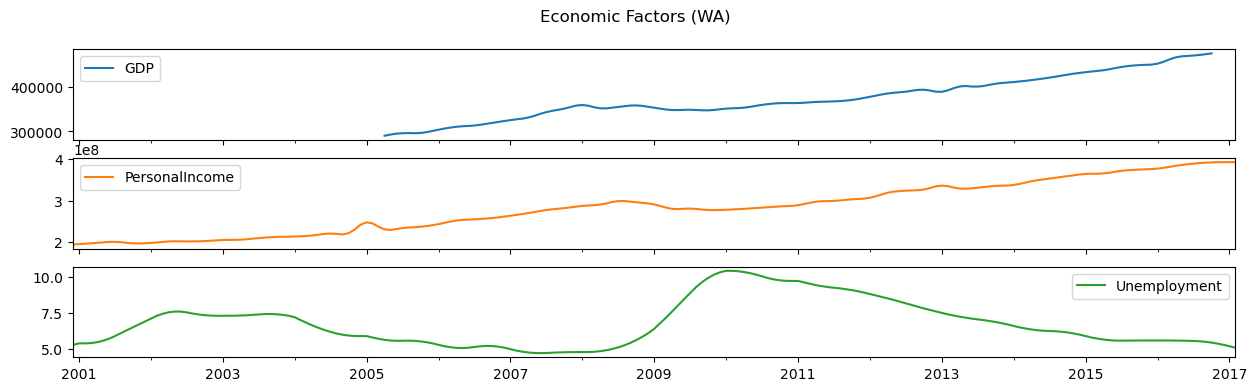

In [26]:
from datetime import date
# features:
# state
# gdp per quarter between 2005-2016
# personal income per quarter between 1950-2016
# Unemployment rate per month 2000-2016


# Let's start with WA for now however folks will be traveling from all states
# We might also consider that 'bell weather' states might exist. 
state = 'WA' # df_econ.state
df = df_econ[df_econ.state == state] # "L'État, c'est moi" --Louis XIV
cols = df_econ.columns.tolist() 

# Create a timeseries for our analysis
pi, pi_time = [], []
gdp, gdp_time = [], []
ur, ur_time = [], []
for s in cols:
    # use personal_income dates as index
    g1 = re.match('([0-9]{4})Q([1-4])_personal_income', s)
    if g1:
        yyyy, q = g1.groups()        
        t = pd.Timestamp(year=int(yyyy), month=1, day=1) + pd.offsets.MonthBegin(int(q)*3)
        pi_time.append(t)
        pi.append(float(df[s]))
        
    g2 = re.match('([0-9]{4})/([12][0-9])_ur', s)
    if g2:
        yyyy, m = g2.groups()        
        t = pd.Timestamp(year=int(yyyy), month=1, day=1) + pd.offsets.MonthBegin(int(m)+1)
        ur_time.append(t)
        ur.append(float(df[s]))
    
    g3 = re.match('([0-9]{4})Q([1-4])_gdp', s)
    if g3:
        yyyy, q = g3.groups()        
        t = pd.Timestamp(year=int(yyyy), month=1, day=1) + pd.offsets.MonthBegin(int(q)*3)
        gdp_time.append(t)
        gdp.append(float(df[s]))

# define our period 
min_date = min(min(pi_time), min(gdp_time), min(ur_time))
max_date = max(max(pi_time), max(gdp_time), max(ur_time))
index = pd.date_range(start=min_date, end=max_date, freq='MS')

# collect our time series data
cdf_econ = pd.DataFrame(index=index, columns=['GDP', 'PersonalIncome', 'Unemployment'], dtype=float)
for t, v in zip(pi_time, pi):
    cdf_econ.loc[t].PersonalIncome = v
for t, v in zip(gdp_time, gdp):
    cdf_econ.loc[t].GDP = v
for t, v in zip(ur_time, ur):
    cdf_econ.loc[t].Unemployment = v

# impute our predictors
cdf_econ['PersonalIncome'] = cdf_econ['PersonalIncome'].interpolate(method='spline', order=2)
cdf_econ['Unemployment'] = cdf_econ['Unemployment'].interpolate(method='polynomial', order=2)
cdf_econ['GDP'] = cdf_econ['GDP'].interpolate(method='polynomial', order=2)

df_chop = cdf_econ.loc['2000-12-01':]
df_chop.plot(subplots=True, y=['GDP', 'PersonalIncome','Unemployment'], figsize=(15,4))
plt.suptitle(f'Economic Factors ({state})')

(min(gdp_time), max(gdp_time)), (min(ur_time), max(ur_time))
cdf_econ.loc['20050401': ]

In [27]:
df_chop.tail()

,GDP,PersonalIncome,Unemployment
2016-10-01,474732.0,3.919483e+08,5.453466
2016-11-01,NaN,3.924200e+08,5.383416
2016-12-01,NaN,3.926190e+08,5.300000
2017-01-01,NaN,3.925586e+08,5.200000
2017-02-01,NaN,3.922277e+08,5.100000


##  Appendix 1. Birds eye

For paucity of time, I will just give a birds eye view of the solution:

First we will make analogy of this problem with self driving car problem. We will treat prices and amenities act as a steering wheel and brakes and acceleration pedal. where as demand, state of economy calendar etc show the complex terrain, road and traffic. 

Just like a driver needs to adjust their speed and apply the brakes or accelerator depending on the road conditions and traffic, Airbnb hosts need to adjust their prices and amenities based on the demand, state of the economy, and other factors. These factors act as the "terrain" that the Airbnb host must navigate, and they must be able to adapt to changing conditions in order to maximize their success.

For example, if demand for Airbnb properties is high due to a major event or holiday, hosts may need to increase their prices to take advantage of the increased demand. On the other hand, if the economy is struggling and there is less demand for travel, hosts may need to lower their prices or offer discounts in order to attract customers.

Similarly, just as a driver needs to be aware of road conditions, traffic patterns, and potential hazards, Airbnb hosts need to be aware of the availability of competing properties, local regulations, and other factors that could impact their success. By using data and analytics to track these factors and adjust their strategies accordingly, hosts can stay competitive and maximize their profits.

Overall, the analogy of a driver navigating a complex terrain is a useful way to think about the challenges faced by Airbnb hosts and the strategies they can use to succeed in a highly competitive and constantly evolving market.

AI is used for making pricing and amenity recommendations just as a driver would use the accelerator and brake pedals and steering wheel based on road conditions.

The machine learning step in the proposed architecture involves training a model using reinforcement learning techniques to make pricing and amenity recommendations. Reinforcement learning is a type of machine learning that involves an agent interacting with an environment and learning from feedback in the form of rewards. In this case, the agent is the pricing and amenity recommendation system, and the environment is the Airbnb market.

The agent learns to adjust prices and amenities based on the complex terrain of the Airbnb market, which is represented by features such as the state of the economy, demographics, and real estate prices. The agent receives feedback in the form of rewards, which are based on the success of the host in terms of occupancy rates, customer satisfaction, and revenue.

By using reinforcement learning techniques, the agent can learn to make optimal pricing and amenity recommendations in real-time based on the current market conditions. This allows hosts to maximize their success on the platform while also providing customers with the best possible experience.

here are some more details on how AI can be used to make pricing and amenity recommendations for Airbnb listings, based on the analogy of a driver navigating a complex terrain:

State Representation: In order to make pricing and amenity recommendations, the current state of the market needs to be represented in a way that is understandable by the agent. This could include features such as the current demand for listings, the state of the economy, and the prices of similar listings in the area.

Action Space: The agent needs to be able to take actions based on the current state of the market. In this case, the actions are the prices and amenities that the host sets for their listing.

Reward Function: The agent receives feedback in the form of rewards, which are based on the success of the host. The reward function could be based on metrics such as occupancy rates, customer satisfaction, and revenue. The agent's goal is to maximize the expected reward over time.

Reinforcement Learning Algorithm: There are several reinforcement learning algorithms that could be used to train the agent, such as Q-learning or deep reinforcement learning algorithms like deep Q-networks (DQN). The agent interacts with the environment (i.e., the market) by taking actions based on the current state and receiving feedback in the form of rewards. The agent learns to maximize the expected reward over time by updating its action policy based on the rewards it receives.

Deployment: Once the agent has been trained, it can be deployed in a production environment to make real-time pricing and amenity recommendations. The agent can take in data about the current state of the market, and use its learned action policy to recommend prices and amenities for each listing.

Some additional details on each of these steps:

State Representation: In order to represent the current state of the market, data needs to be collected and preprocessed to create relevant features that are indicative of the current market conditions. This could involve using techniques such as clustering and regression to identify patterns in the data.

Action Space: The action space for the agent is the set of possible prices and amenities that a host can set for their listing. The agent needs to be able to determine the optimal action to take given the current state of the market. This could involve using techniques such as exploration-exploitation strategies to balance the need to explore new actions with the need to exploit known good actions.

Reward Function: The reward function is a critical component of the reinforcement learning algorithm. The reward function should be designed to incentivize the agent to take actions that lead to the best outcome for the host. The reward function could be a simple function such as a linear combination of occupancy rates, customer satisfaction, and revenue, or it could be a more complex function that takes into account multiple factors.

Reinforcement Learning Algorithm: The reinforcement learning algorithm used to train the agent will depend on the complexity of the problem and the amount of data available. Q-learning is a simple and effective algorithm that can be used for small-scale problems, while deep reinforcement learning algorithms like DQN are better suited for larger-scale problems with more complex state and action spaces.

Deployment: Once the agent has been trained, it can be deployed in a production environment using a web application or API. The agent can take in data about the current state of the market and make real-time pricing and amenity recommendations for each listing. The host can then use these recommendations to set their prices and amenities, with the goal of maximizing their success on the platform.

## Appendix 2. File exploration 

In [28]:
'''
def getFiles(files, subs):
    return [i for i in files if subs in i]
files = [
    '10764_._boston_calendar.csv',
    '31943_._venues.csv',
    '76809_._real_estate.csv',
    '90549_._seattle_reviews.csv',
    '13589_._econ_state.csv',
    '36775_demographics.csv',
    '80715_._seattle_listings.csv',
    '16575_._boston_reviews.csv',
    '37070_._seattle_calendar.csv',
    '82435_._demographics.csv',
    '18189_seattle_listings.csv',
    '61255_econ_state.csv',
    '85924_._boston_listings.csv']
    
valid_files = ['18189_seattle_listings.csv', '36775_demographics.csv', '61255_econ_state.csv']
for f in valid_files:
    print('=' *30)
    print(f'{f}:')
    print('=' *30)
    fd = pd.read_csv(f)
    display(fd.info())
''';